<a href="https://colab.research.google.com/github/sv650s/sb-capstone/blob/master/2019_08_1_preloaded_embeddings_word2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pre-trained Embeddings notebook


In the previous notebook [2019-07-30_deep_learning_summary](https://github.com/sv650s/sb-capstone/blob/master/2019_07_30_deep_learning_summary.ipynb) we looked at the results for various deep learning models. There were 2 models that came back with the best results:

* 1 layer bi direcitonal GRU with attention
* 3 layer CNN with maxpooling - we train this with 15 epoch without early stopping

Overall, GRU model offered better precision however poor recall

CNN had a good balance for F1 (precision and recall) scores for class 2, 3, 4 - our problem classes, but did poorly for our class 1 and 5

In this notebook, we will use pre-trained word embeddings for both models. Idea is that in our previous notebooks, embeddings were random to start with and as we train the model as well as embeddings.

With pre-trained embeddings, we should see improvements in our model in term of training time since the embedding vectors are pre-trained


Pre-trained word vectors will come from Google's Word2Vec model pre-trained on Google News: https://github.com/mmihaltz/word2vec-GoogleNews-vectors

In [1]:
from google.colab import drive
import sys
drive.mount('/content/drive')
DRIVE_DIR = "drive/My Drive/Springboard/capstone"

# add this to sys patch so we can import utility functions
sys.path.append(DRIVE_DIR)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, GRU, SpatialDropout1D, Bidirectional
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping
from keras.models import load_model
from sklearn.model_selection import train_test_split
from keras.optimizers import SGD
from sklearn.preprocessing import OneHotEncoder
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
import pandas as pd
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import pickle
from datetime import datetime
from sklearn.metrics import confusion_matrix, classification_report
import os
import seaborn as sns
import matplotlib.pyplot as plt


# custom utility functions
import util.dict_util as du
import util.plot_util as pu
import util.file_util as fu
import util.keras_util as ku


sns.set()

import logging
logging.basicConfig(level=logging.INFO)

DATE_FORMAT = '%Y-%m-%d'
TIME_FORMAT = '%Y-%m-%d %H:%M:%S'
DATA_FILE = f"{DRIVE_DIR}/data/amazon_reviews_us_Wireless_v1_00-preprocessed-110k.csv"
LABEL_COLUMN = "star_rating"
REVIEW_COLUMN = "review_body"


Using TensorFlow backend.


In [3]:
import tensorflow as tf
# checl to make sure we are using GPU here
tf.test.gpu_device_name()

''

In [0]:
df = pd.read_csv(f"{DATA_FILE}")
ratings = df[LABEL_COLUMN]
reviews = df[REVIEW_COLUMN]

## Preprocessing our Data

Put code from previous notebooks into [keras_util.py](https://github.com/sv650s/sb-capstone/blob/master/util/keras_util.py)

In [5]:
X_train, X_test, y_train, y_test, t, max_sequence_length = ku.preprocess_file(df, 
                                                                              REVIEW_COLUMN, LABEL_COLUMN, 
                                                                              0.99, 
                                                                              use_oov_token=False)


One hot enocde label data...
Splitting data into training and test sets...


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


Vocabulary size=40788
Number of Documents=84032
Max Sequence Length: 186


In [0]:
import numpy as np
from gensim.models import KeyedVectors

def load_pretrained_embeddings(word_to_index, max_features, embedding_size, embedding_file_path, normalize=True):    
    """
    This builds a matrix of word vectors that are in our vocabulary
    :return: matrix of word vectors - index is the index in our vocabulary, each row is the word vector    
    """
    
    # def get_coefs(word,*arr): 
    #     return word, np.asarray(arr, dtype='float32')


    key_vectors = KeyedVectors.load_word2vec_format(embedding_file_path, 
                                                    binary=True)
    if normalize:
      # normalize our vectors to make training faster
      key_vectors.init_sims(replace=True)


    # turns the embedding file into a dictionary key = word, value = word vector
    # embeddings_index = dict(get_coefs(*row.split(" ")) 
    #                             for row in open(embedding_file_path, encoding="utf8", errors='ignore') 
    #                                 if len(row)>100)

    # convert the values into a array of word vectors
    # all_embs = np.stack(embeddings_index.values())
    # # get mean and std of embedding vectors so we can normalize them later
    # emb_mean, emb_std = all_embs.mean(), all_embs.std()
    # embed_size = all_embs.shape[1]
    # print(f'embed_size {embed_size}')
    # print(f'max_features {max_features}')
    
    
    # nb_words = min(max_features, len(word_to_index))
    nb_words = max_features
    # print(f'({nb_words}, {embedding_size})')

    embedding_matrix = np.random.normal(size=(nb_words, embedding_size))
    
    print("Create our matrix of embeddings...")
    # loop through all words in our vocabulary
    found_counter = 0
    notfound_counter = 0
    for word, idx in word_to_index.items():
        if idx >= max_features - 1 or word not in key_vectors.wv.vocab: 
            notfound_counter += 1
            continue
        if normalize:
          embedding_vector = key_vectors.word_vec(word, use_norm=True)
        else:
          embedding_vector = key_vectors.get_vector(word)

        if embedding_vector is not None: 
            found_counter += 1
            embedding_matrix[idx] = embedding_vector
    print(f'found: {found_counter} not found: {notfound_counter}')

    return embedding_matrix

In [7]:
# total umber of words in our corpus
# adding 1 because Embedding layer suggests that we pass in vocab size + 1
# the shape of the embedding matrix/weights need to match this
MAX_FEATURES = len(t.word_index) + 1
EMBED_SIZE = 300
pg_embeddings = load_pretrained_embeddings(word_to_index=t.word_index, 
                                           max_features=MAX_FEATURES, 
                                           embedding_size=EMBED_SIZE, 
                                           embedding_file_path=f'{DRIVE_DIR}/data/embeddings/GoogleNews-vectors-negative300.bin')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Create our matrix of embeddings...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


found: 25259 not found: 15529


In [8]:
print(max([value for key, value in list(t.word_index.items())]))
print(min([value for key, value in list(t.word_index.items())]))
len(pg_embeddings)

40788
1


40789

In [0]:
MODEL_NAME = "biGRU_1layer_attention-word2vec_normalized"
EPOCHS  = 50
BATCH_SIZE = 128
GRU_DIM = 250 # total GRU units

In [10]:
print(f'Max Features: {MAX_FEATURES}')
print(f'max_sequence_length {max_sequence_length}')
print(f'pg_embeddings.shape {pg_embeddings.shape}')
print(f'EMBED_SIZE {EMBED_SIZE}')

Max Features: 40789
max_sequence_length 186
pg_embeddings.shape (40789, 300)
EMBED_SIZE 300


In [11]:
import keras
from keras.layers import CuDNNGRU
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# slow down the learnig rate if we are seeing a plateau to get a better model
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.4,
                              patience=2, 
                              min_lr=0.00001,
                             mode='auto')

early_stop = EarlyStopping(monitor='val_loss', 
                           patience=2, 
                           mode='auto', 
                           verbose=1,
                          restore_best_weights=True)


inp = keras.layers.Input(shape=(max_sequence_length,))
x = keras.layers.Embedding(MAX_FEATURES, 
                    EMBED_SIZE, 
                    input_length=max_sequence_length, 
                    weights=[pg_embeddings], trainable=True)(inp)
x = ku.AttentionLayer(max_sequence_length)(x)
x = keras.layers.Dense(GRU_DIM*2, activation='relu')(x)
x = keras.layers.Dropout(rate=0.2)(x)
x = keras.layers.Dense(GRU_DIM, activation='relu')(x)
x = keras.layers.Dropout(rate=0.2)(x)

outp = keras.layers.Dense(5, activation='softmax')(x)
# initialize the model
model = keras.models.Model(inputs=inp, outputs=outp)
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])



# wrap our model in our class so we can record metrics
mw = ku.ModelWrapper(model, MODEL_NAME, LABEL_COLUMN, DATA_FILE,
                     embedding=EMBED_SIZE,
                     tokenizer=t, description="Pre-trained Embedding - paragram")

network_history = mw.fit(X_train, y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      verbose=1,
                      validation_split=0.2,
                      callbacks=[reduce_lr, early_stop])


W0802 08:43:33.149106 140702371489664 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0802 08:43:33.152252 140702371489664 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0802 08:43:33.159449 140702371489664 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0802 08:43:33.173345 140702371489664 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0802 08:43:33.175169 1407023714

Train on 67225 samples, validate on 16807 samples
Epoch 1/50
67225/67225 [==============================] - 242s 4ms/step - loss: 1.2383 - acc: 0.5501 - val_loss: 1.0722 - val_acc: 0.6014
Epoch 2/50
67225/67225 [==============================] - 238s 4ms/step - loss: 0.9287 - acc: 0.6410 - val_loss: 0.9116 - val_acc: 0.6435
Epoch 3/50
67225/67225 [==============================] - 231s 3ms/step - loss: 0.8631 - acc: 0.6642 - val_loss: 0.9101 - val_acc: 0.6487
Epoch 4/50
67225/67225 [==============================] - 236s 4ms/step - loss: 0.8231 - acc: 0.6805 - val_loss: 0.8783 - val_acc: 0.6630
Epoch 5/50
67225/67225 [==============================] - 228s 3ms/step - loss: 0.7897 - acc: 0.6946 - val_loss: 0.8791 - val_acc: 0.6634
Epoch 6/50
67225/67225 [==============================] - 227s 3ms/step - loss: 0.7631 - acc: 0.7069 - val_loss: 0.9067 - val_acc: 0.6581
Restoring model weights from the end of the best epoch
Epoch 00006: early stopping


## Evaluate our Model

In [12]:
mw.evaluate(X_test, y_test)

Running model.evaluate...
28011/28011 [==============================] - 7s 261us/step
Running model.predict...
Unencode predictions...
Generating confusion matrix...
Calculating ROC AUC...
Getting classification report...


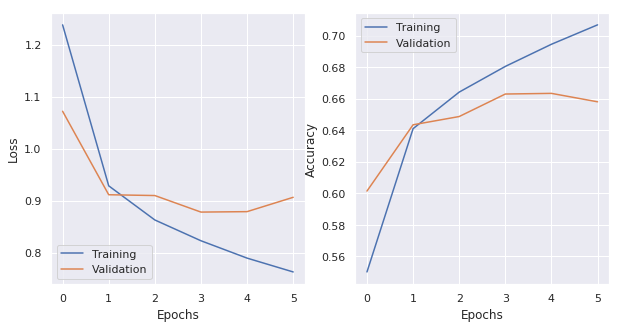

In [13]:
pu.plot_network_history(mw.network_history)

In [14]:
print(f'Accuracy: {mw.scores[1]}')

Accuracy: 0.6651315554656746


In [15]:
mw.confusion_matrix

array([[ 3253,    70,   317,    61,   267],
       [  981,    72,   421,   170,   227],
       [  586,    77,   751,   534,   583],
       [  217,    27,   551,  1079,  2878],
       [  268,    12,   339,   794, 13476]])

In [16]:
print(mw.classification_report)

              precision    recall  f1-score   support

           1       0.61      0.82      0.70      3968
           2       0.28      0.04      0.07      1871
           3       0.32      0.30      0.31      2531
           4       0.41      0.23      0.29      4752
           5       0.77      0.91      0.83     14889

    accuracy                           0.67     28011
   macro avg       0.48      0.46      0.44     28011
weighted avg       0.61      0.67      0.62     28011



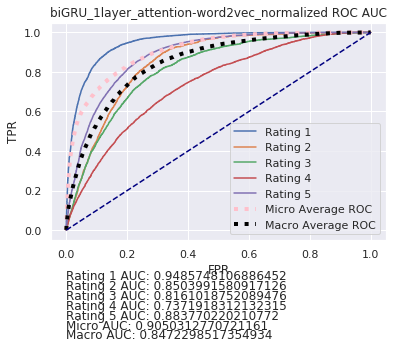

In [17]:
pu.plot_roc_auc(MODEL_NAME, mw.roc_auc, mw.fpr, mw.tpr)

In [18]:
mw.save(DRIVE_DIR, append_report=True)

description: amazon_reviews_us_Wireless_v1_00-preprocessed-110k-biGRU_1layer_attention-word2vec_normalized-186-star_rating
Saving model file: drive/My Drive/Springboard/capstone/models/amazon_reviews_us_Wireless_v1_00-preprocessed-110k-biGRU_1layer_attention-word2vec_normalized-186-star_rating-model.h5
Saving network history file: drive/My Drive/Springboard/capstone/models/amazon_reviews_us_Wireless_v1_00-preprocessed-110k-biGRU_1layer_attention-word2vec_normalized-186-star_rating-history.pkl
Saving to report file: drive/My Drive/Springboard/capstone/reports/2019-08-02-dl_prototype-report.csv
Saving report file...
